## Tests of Repliseq Track

Recapitulate Y Scaled (Z-Score) and treat as one-way ANOVA table

In [4]:
source("_targets.R")
library(dplyr)
library(GenomicRanges)
library(tibble)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    findMatches


The following objects are mask

In [6]:
tar_load(
  c(
    chromosome_pericetromere_label,
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr,
    repli.timing_Kc167_chr,
    repli.timing_S2_chr
  )
)

In [24]:
Y <- tibble(
  chr = c(names(chr.lengths), "rDNA"),
  xmin = rep(2500, length(chr)) %>% replace(match("rDNA", chr), 37500),
  xmax = floor((c(chr.lengths, seqlengths(repli.timing_Germline_chr)["rDNA"]) - 2500) / 5000) * 5000,
  Germline = list(repli.timing_Germline_chr),
  Somatic = list(repli.timing_Somatic_chr),
  Kc167 = list(repli.timing_Kc167_chr),
  S2 = list(repli.timing_S2_chr),
) %>%
  group_by(chr, xmin, xmax) %>%
  reframe(
    x = seq(xmin, xmax, by = 5000),
    region = (
      as.character(chr) %>%
        paste0(
          replace(
            rep("", length(x)),
            chromosome_pericetromere_label %>%
              findOverlaps(
                GRanges(
                  chr,
                  IRanges(x, width=1),
                  seqlengths = seqlengths(repli.timing_Germline_chr)
                )
              ) %>%
              to(),
            "C"
          )
        ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      )
    ),
    across(
      !matches("^(x|region)$"),
      list(
        LOESS = ~ (
          loess(
            y.track ~ x.track,
            tibble(
              x.track = .x[[1]][seqnames(.x[[1]]) == chr] %>% mid(),
              y.track = .x[[1]][seqnames(.x[[1]]) == chr]$score,
            ),
            span = if (chr == "rDNA") {
              0.1
            } else {
              0.025
            }
          ) %>%
          predict(tibble(x.track = x))
        )
      )
    )
  ) %>%
  subset(select = -c(xmin, xmax))
subset(Y, region == "rDNA")

chr,x,region,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
rDNA,37500,rDNA,0.6482017,-0.6204086,-0.9240146,-0.8223618
rDNA,42500,rDNA,0.7099135,-0.5879558,-0.9338242,-0.9026897
rDNA,47500,rDNA,0.7568527,-0.6177137,-0.9291707,-0.8665072
rDNA,52500,rDNA,-0.4198505,-0.6580948,-0.9769341,-0.9492365
rDNA,57500,rDNA,0.6880967,-0.6337990,-0.8950174,-0.8244144
rDNA,62500,rDNA,0.6249556,-0.3777080,-0.8714755,-0.8432189
rDNA,67500,rDNA,0.7103718,-0.5854864,-0.9253684,-0.8596512


In [32]:
sapply(
  levels(Y$region),
  \(n) with(
    subset(Y, region == n & x %% 20000 == 2500),
    t.test(qlogistanh(Germline_LOESS), qlogistanh(Somatic_LOESS))
  ),
  simplify=FALSE
)

$`2L`

	Welch Two Sample t-test

data:  qlogistanh(Germline_LOESS) and qlogistanh(Somatic_LOESS)
t = 6.5089, df = 2213.6, p-value = 9.333e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1578006 0.2938865
sample estimates:
   mean of x    mean of y 
 0.224035555 -0.001807994 


$`2LC`

	Welch Two Sample t-test

data:  qlogistanh(Germline_LOESS) and qlogistanh(Somatic_LOESS)
t = 11.229, df = 94.68, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.8454739 1.2086450
sample estimates:
 mean of x  mean of y 
-0.1369713 -1.1640307 


$`2RC`

	Welch Two Sample t-test

data:  qlogistanh(Germline_LOESS) and qlogistanh(Somatic_LOESS)
t = 5.5222, df = 421.81, p-value = 5.864e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2139929 0.4505283
sample estimates:
 mean of x  mean of y 
-0.6962408 -1.0285014 


$`2R`

	W

In [25]:
YS <- Y[
  c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
] %>%
  as.matrix() %>%
  scale() %>%
  t() %>%
  scale() %>%
  t()
YS[Y$chr == "Y", ] <- (
  YS[Y$chr == "Y", c(1, 2, 4)] %>%
    t() %>%
    scale() %>%
    t() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          0, 0, 0,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)
tail(YS)

,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
"[27504,]",1.4416166,-0.196228455,-0.39059482,-0.8547933
"[27505,]",1.4583548,-0.252279529,-0.40024781,-0.8058275
"[27506,]",0.9181662,0.451990640,0.02696463,-1.3971214
"[27507,]",1.4642864,-0.287717381,-0.38712951,-0.7894395
"[27508,]",1.3859842,0.000566436,-0.45059642,-0.9359542
"[27509,]",1.4510692,-0.217053878,-0.40977718,-0.8242381


In [21]:
table(Y$region)


  2L  2LC  2RC   2R   3L  3LC  3RC   3R    4    X    Y rDNA 
4438  264 1130 3926 4631  990  846 5569  269 4707  732    7 

In [ ]:
sapply(
  levels(Y$region),
  \(n) YS %>%
    subset(Y$region == n & Y$x %% 20000 == 2500) %>%
    melt() %>%
    lm(value ~ Var2, .) %>%
    anova(),
  simplify=FALSE
)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,7.519516,2.5065052,3.346553,0.01831749
Residuals,4436,3322.480484,0.7489812,NA,NA
,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,128.3176,42.7725318,159.5935,1.14003e-58
Residuals,260,69.6824,0.2680092,NA,NA
,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,80.93249,26.9774969,39.61972,2.414984e-24


ANOVA of Y Scaled & Testing the Posterior Distribution of the rDNA

In [ ]:
source("_targets.R")

In [ ]:
line_cmap <- c(chic_line_track_colors$germline, chic_line_track_colors$somatic, hcl(50, 102, 57), hcl(255, 102, 57))

library(forcats)

tar_load(chic.tile.diameter_1000_chr | repli.peaks_chr)
tar_load(matches("repli.timing_.*chr$"))
tar_load(chromosome_pericetromere_label)

In [ ]:
chromosome_pericetromere_label

GRanges object with 4 ranges and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]       2L 22192401-23513712      *
  [2]       2R         1-5651400      *
  [3]       3L 23154101-28110227      *
  [4]       3R         1-4229200      *
  -------
  seqinfo: 4 sequences from an unspecified genome; no seqlengths

In [ ]:
enframe(chr.lengths/1000/1000)

name,value
<chr>,<dbl>
2L,23.513712
2R,25.286936
3L,28.110227
3R,32.079331
4,1.348131
X,23.542271
Y,3.667352


In [ ]:
repli.peaks_chr[[6]]

GRanges object with 766 ranges and 2 metadata columns:
                                                      seqnames        ranges
                                                         <Rle>     <IRanges>
                          2L.Kc167Later                     2L   34001-70000
                      2L.Kc167Earlier.1                     2L 138001-233000
                      2L.Kc167Earlier.2                     2L 527001-590000
                        2L.Kc167Later.3                     2L 625001-650000
                        2L.Kc167Later.4                     2L 669001-789000
                                    ...                    ...           ...
  Unmapped_Scaffold_38_D1625.Kc167Later Unmapped_Scaffold_38..       1-28305
  Y_mapped_Scaffold_12_D1771.Kc167Later Y_mapped_Scaffold_12..       1-66439
  Y_mapped_Scaffold_18_D1698.Kc167Later Y_mapped_Scaffold_18..       1-34521
  Y_mapped_Scaffold_23_D1638.Kc167Later Y_mapped_Scaffold_23..       1-31460
             21100002

In [ ]:
names(repli.peaks_chr)

[1] "Germline_Somatic"     "Germline_Kc167"       "Germline_S2"         
[4] "Somatic_Kc167"        "Somatic_S2"           "Kc167_S2"            
[7] "Dynamic_Static_Model"

In [ ]:
repli.peaks_chr[c(2, 4, 6)] <- repli.peaks_chr[c(2, 4, 6)] %>%
  sapply(
    \(gr) gr[!grepl("^Y", seqnames(gr))],
    simplify=F
  )

In [ ]:
tail(repli.peaks_chr[[6]])

GRanges object with 6 ranges and 2 metadata columns:
                                                         seqnames
                                                            <Rle>
                          X.Kc167Later.115                      X
  3Cen_mapped_Scaffold_41_D1641.Kc167Later 3Cen_mapped_Scaffold..
     Unmapped_Scaffold_13_D1782.Kc167Later Unmapped_Scaffold_13..
     Unmapped_Scaffold_35_D1599.Kc167Later Unmapped_Scaffold_35..
     Unmapped_Scaffold_38_D1625.Kc167Later Unmapped_Scaffold_38..
                211000022278415.Kc167Later        211000022278415
                                                      ranges strand |   NegDiff
                                                   <IRanges>  <Rle> | <numeric>
                          X.Kc167Later.115 22876001-23194000      * | -1.278509
  3Cen_mapped_Scaffold_41_D1641.Kc167Later           1-22604      * | -0.571954
     Unmapped_Scaffold_13_D1782.Kc167Later           1-25537      * | -0.448105
     Unmapped_Scaff

In [ ]:
Y <- tibble(
  chr = names(chr.lengths),
  xmin = 2500,
  xmax = floor((chr.lengths - 2500) / 5000) * 5000,
  Germline = list(repli.timing_Germline_chr),
  Somatic = list(repli.timing_Somatic_chr),
  Kc167 = list(repli.timing_Kc167_chr),
  S2 = list(repli.timing_S2_chr),
) %>%
  group_by(chr, xmin, xmax) %>%
  reframe(
    x = seq(xmin, xmax, by = 5000),
    region = (
      as.character(chr) %>%
        paste0(
          replace(
            rep("", length(x)),
            chromosome_pericetromere_label %>%
              findOverlaps(
                GRanges(
                  chr,
                  IRanges(x, width=1),
                  seqlengths = seqlengths(repli.timing_Germline_chr)
                )
              ) %>%
              to(),
            "C"
          )
        ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      )
    ),
    across(
      !matches("^(x|region)$"),
      list(
        LOESS = ~ (
          loess(
            y.track ~ x.track,
            tibble(
              x.track = .x[[1]][seqnames(.x[[1]]) == chr] %>% mid(),
              y.track = .x[[1]][seqnames(.x[[1]]) == chr]$score,
            ),
            span = 0.025
          ) %>%
          predict(tibble(x.track = x))
        )
      )
    )
  ) %>%
  subset(select = -c(xmin, xmax))

In [ ]:
sum(is.na(Y$region))

[1] 0

In [ ]:
rDNA <- mapply(
  \(gr, v_orig) (
    (
      gr[
        seqnames(gr) == "rDNA" &
          between(mid(gr), 37000, 77000)
      ]$score %>%
        mean()
    ) -
      mean(v_orig)
  ) /
    sd(v_orig),
  list(
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr,
    repli.timing_Kc167_chr,
    repli.timing_S2_chr
  ),
  Y[
    c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
  ]
)
Y <- rbind(
  Y,
  tibble(
    chr = "rDNA",
    x = 57000,
    region = "rDNA",
    as_tibble(
      setNames(
        as.list(rDNA),
        colnames(Y)[4:7]
      )
    )
  )
)
tail(Y)

chr,x,region,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Y,3637500,Y,-0.2551883,-0.2256387,-0.7050496,-0.4268229
Y,3642500,Y,-0.2519863,-0.2102737,-0.6260181,-0.3906424
Y,3647500,Y,-0.2497008,-0.1900902,-0.5144327,-0.3388503
Y,3652500,Y,-0.2511598,-0.1643056,-0.3685433,-0.2707145
Y,3657500,Y,-0.2629694,-0.1327978,-0.1852171,-0.1852090
rDNA,57000,rDNA,1.2700077,-1.5555987,-1.9353602,-2.7976166


In [ ]:
Y[Y$chr == "Y", 4:7] <- (
  Y[Y$chr == "Y", c(4, 5, 7)] %>%
    as.matrix() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          NA, NA, NA,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)
tail(Y)

chr,x,region,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Y,3637500,Y,-0.2551883,-0.2256387,NA,-0.4268229
Y,3642500,Y,-0.2519863,-0.2102737,NA,-0.3906424
Y,3647500,Y,-0.2497008,-0.1900902,NA,-0.3388503
Y,3652500,Y,-0.2511598,-0.1643056,NA,-0.2707145
Y,3657500,Y,-0.2629694,-0.1327978,NA,-0.1852090
rDNA,57000,rDNA,1.2700077,-1.5555987,-1.93536,-2.7976166


In [ ]:
write.table(
  cbind(
    Y[c("chr", "region", "x")],
    round(as.matrix(Y[4:7]), digits=3)
  ),
  "illustrations/Replication_Bayes_LOESS.tsv",
  quote = F,
  sep = "\t",
  row.names = F,
  na = ""
)


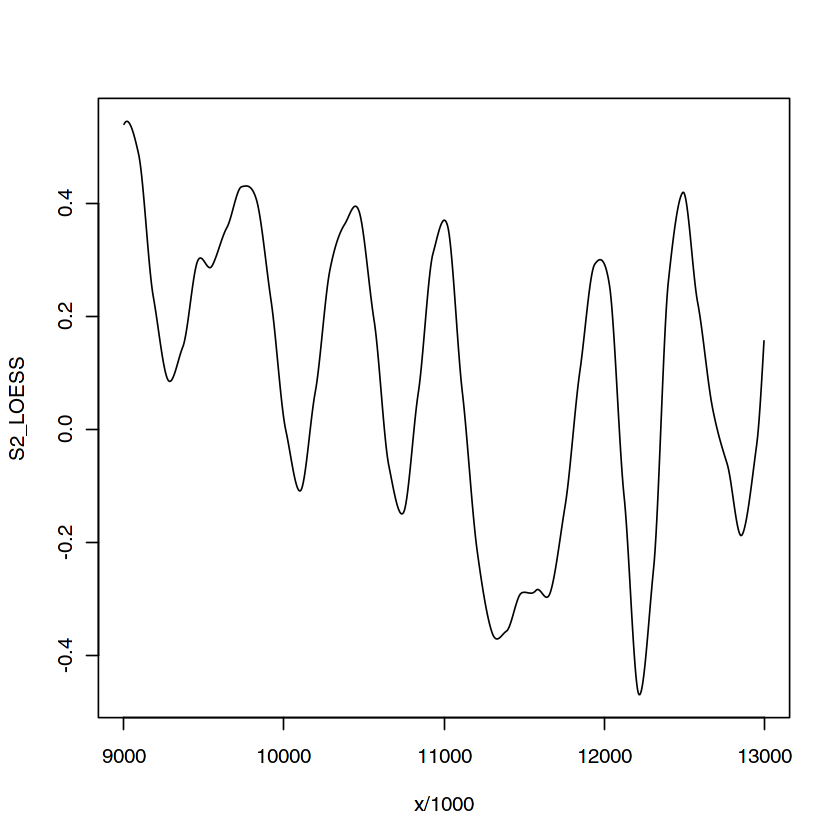

In [ ]:
with(subset(Y, region == "2L" & between(x, 9*1000*1000, 13*1000*1000)), plot(x/1000, S2_LOESS, type='l'))


In [ ]:
YS <- Y[
  c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
] %>%
  as.matrix() %>%
  scale() %>%
  t() %>%
  scale() %>%
  t()
YS[Y$chr == "Y", ] <- (
  YS[Y$chr == "Y", c(1, 2, 4)] %>%
    t() %>%
    scale() %>%
    t() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          0, 0, 0,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)
tail(YS)

PCA <- prcomp(t(YS))
PCA$x %>%
  as.data.frame() %>%
  rownames_to_column("individual") %>%
  as_tibble() %>%
  print()


,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
"[27498,]",0.07483779,0.9604786,0.000000,-1.03531642
"[27499,]",-0.04177535,1.0202330,0.000000,-0.97845767
"[27500,]",-0.26002646,1.1043282,0.000000,-0.84430175
"[27501,]",-0.63157211,1.1529464,0.000000,-0.52137433
"[27502,]",-1.02107990,0.9774948,0.000000,0.04358505
"[27503,]",1.34525780,-0.1381486,-0.133108,-1.07400125


# A tibble: 4 × 5
  individual         PC1    PC2   PC3       PC4
  <chr>            <dbl>  <dbl> <dbl>     <dbl>
1 Germline_LOESS -146.     39.2 -25.7  4.76e-13
2 Somatic_LOESS    92.9   119.  -12.5 -1.38e-12
3 Kc167_LOESS       7.59  -50.0 114.   8.70e-13
4 S2_LOESS         45.8  -108.  -75.7  5.07e-14


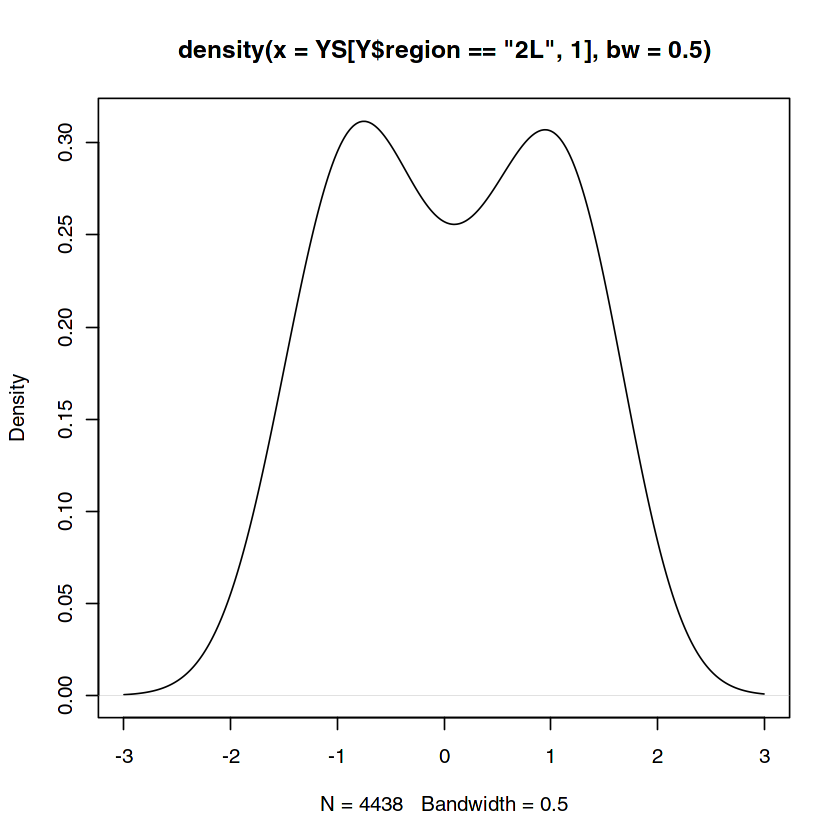

In [ ]:
plot(density(YS[Y$region == "2L", 1], bw=0.5))

In [ ]:
print(apply(YS[Y$region == "2L", ], 2, sd))

Germline_LOESS  Somatic_LOESS    Kc167_LOESS       S2_LOESS 
     0.9606863      0.9164612      0.7095344      0.8497575 


In [ ]:
lm(
  value ~ Var2,
  melt(YS[Y$region == "3L", ]),
  subset = Var1 %% 3 == 1
) %>%
  anova()

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,36.53697,12.1789891,16.35716,1.382548e-10
Residuals,6172,4595.46303,0.7445663,NA,NA


In [ ]:
lm(
  value ~ Var2,
  melt(YS[Y$region == "3L", ]),
  subset = Var1 %% 20 == 10
) %>%
  anova()

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,4.722028,1.5740094,2.103907,0.09816497
Residuals,924,691.277972,0.7481363,NA,NA


In [ ]:
tar_load(repli.peaks_chr)

repli.peaks_chr$Dynamic_Static_Model %>% subset(seqnames == "rDNA")

GRanges object with 1 range and 2 metadata columns:
                       seqnames     ranges strand |   NegDiff   PosDiff
                          <Rle>  <IRanges>  <Rle> | <numeric> <numeric>
  rDNA.GermlineEarlier     rDNA 1001-76973      * | -0.440438   1.35072
  -------
  seqinfo: 1870 sequences from an unspecified genome; no seqlengths

In [ ]:
tar_load(repli.bayes.factor_chr)

subset(repli.bayes.factor_chr, seqnames == "rDNA" & between(start, 37001, 77000)) %>%
  `$`("Dynamic_Static_Model") %>%
  summary()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
7.560e+02 1.150e+09 8.137e+10 8.107e+11 6.205e+11 1.349e+13 

In [ ]:
write.table(
  tibble(
    region = levels(Y$region),
    p.adjust = p.adjust(
      c(
        sapply(
          region[1:11],
          \(region) lm(
            value ~ Var2,
            melt(YS[Y$region == region, ]),
            subset = Var1 %% 20 == 10
          ) %>%
            anova() %>%
            `[`(
              "Var2",
              "Pr(>F)"
            )
        ),
        1 / median(
          subset(repli.bayes.factor_chr, seqnames == "rDNA" & between(start, 37001, 77000)) %>%
            `$`("Dynamic_Static_Model")
        )
      )
    ),
    signif = structure(
      cut(
        p.adjust,
        c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, 1)
      ),
      levels = c("****", "***", "**", "*", ""),
      class = "factor"
    )
  ),
  quote=F,
  sep="\t",
  row.names=F
)

region	p.adjust	signif
2L	0.296626070989817	
2LC	7.64025099231965e-11	****
2RC	0.000985524185941884	***
2R	0.294494897069863	
3L	0.294494897069863	
3LC	0.260724336194536	
3RC	5.35786053113541e-28	****
3R	7.64025099231965e-11	****
4	8.86099917222918e-08	****
X	1.61707555913234e-45	****
Y	8.90622683773367e-13	****
rDNA	8.60267290110591e-11	****


Fisher's Exact Test of Repli Peaks

In [4]:
source("_targets.R")
library(dplyr)
library(GenomicRanges)
library(withr)

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading r

In [6]:
tar_load(
  c(
    chromosome_pericetromere_label,
    repli.peaks_chr
  )
)

In [7]:
tabulate_germline_earlier <- substitute(
  . %>%
      subset(grepl("GermlineEarlier", names(.))) %>%
      `seqlevels<-`(value = c(seqlevels(.), "2LC", "2RC", "3LC", "3RC")) %>%
      `$<-`(
        "region",
        value = paste0(
          as.character(seqnames(.)),
          replace(
            rep(
              "",
              length(.)
            ),
            findOverlaps(
              chromosome_pericetromere_label,
              .
            ) %>%
              to(),
            "C"
          )
        ) %>%
          factor(levels = region)
      ) %>%
      elementMetadata() %>%
      as.data.frame() %>%
      pull("region") %>%
      tabulate()
)

In [8]:
sapply(
  repli.peaks_chr,
  \(gr) str_extract(names(gr), "\\.([A-z]+)", group=1) %>% table()
)

$Germline_Somatic
.
GermlineEarlier   GermlineLater 
            332             203 

$Germline_Kc167
.
GermlineEarlier   GermlineLater 
            467             273 

$Germline_S2
.
GermlineEarlier   GermlineLater 
            402             309 

$Somatic_Kc167
.
SomaticEarlier   SomaticLater 
           299            302 

$Somatic_S2
.
SomaticEarlier   SomaticLater 
           264            308 

$Kc167_S2
.
 Kc 
766 

$Dynamic_Static_Model
.
GermlineEarlier   GermlineLater 
            245             263 


In [9]:
regions <- tibble(
  region = c(
    "2L", "2LC", "2RC", "2R",
    "3L", "3LC", "3RC", "3R",
    "4", "X", "Y"
  ),
  Germline_Somatic = list(
    list(
      repli.peaks_chr$Germline_Somatic %>%
        subset(grepl("GermlineEarlier", names(.))),
      repli.peaks_chr$Germline_Somatic %>%
        subset(grepl("GermlineLater", names(.)))
    )
  ),
  Germline_Kc167 = list(
    list(
      repli.peaks_chr$Germline_Kc167 %>%
        subset(grepl("GermlineEarlier", names(.))),
      repli.peaks_chr$Germline_Kc167 %>%
        subset(grepl("GermlineLater", names(.)))
    )
  ),
  Germline_S2 = list(
    list(
      repli.peaks_chr$Germline_S2 %>%
        subset(grepl("GermlineEarlier", names(.))),
      repli.peaks_chr$Germline_S2 %>%
        subset(grepl("GermlineLater", names(.)))
    )
  ),
  Somatic_Kc167 = list(
    list(
      repli.peaks_chr$Somatic_Kc167 %>%
        subset(grepl("SomaticEarlier", names(.))),
      repli.peaks_chr$Somatic_Kc167 %>%
        subset(grepl("SomaticLater", names(.)))
    )
  ),
  Somatic_S2 = list(
    list(
      repli.peaks_chr$Somatic_S2 %>%
        subset(grepl("SomaticEarlier", names(.))),
      repli.peaks_chr$Somatic_S2 %>%
        subset(grepl("SomaticLater", names(.)))
    )
  ),
  Kc167_S2 = list(
    list(
      repli.peaks_chr$Kc167_S2 %>%
        subset(grepl("Kc167Earlier", names(.))),
      repli.peaks_chr$Kc167_S2 %>%
        subset(grepl("Kc167Later", names(.)))
    )
  ),
) %>%
  reframe(
    region,
    across(
      !region,
      \(gr_copy) sapply(
        gr_copy[[1]],
        \(gr) gr %>%
          `seqlevels<-`(value = c(seqlevels(.), "2LC", "2RC", "3LC", "3RC")) %>%
          `$<-`(
            "region",
            value = paste0(
              as.character(seqnames(.)),
              replace(
                rep(
                  "",
                  length(.)
                ),
                findOverlaps(
                  chromosome_pericetromere_label,
                  .
                ) %>%
                  to(),
                "C"
              )
            ) %>%
              factor(levels = region)
          ) %>%
          elementMetadata() %>%
          as.data.frame() %>%
          pull("region") %>%
          tabulate()
      )
    )
  ) %>%
  print(width=500)

# A tibble: 11 × 7
   region Germline_Somatic[,1]  [,2] Germline_Kc167[,1]  [,2] Germline_S2[,1]
   <chr>                 <int> <int>              <int> <int>           <int>
 1 2L                       59    42                 65    40              68
 2 2LC                       8     0                  7     4               6
 3 2RC                      20     1                 28    14              16
 4 2R                       42    31                 50    50              57
 5 3L                       54    43                 70    50              72
 6 3LC                      12     0                 27     7              13
 7 3RC                       5     2                 22     9              16
 8 3R                       86    34                 93    45             102
 9 4                         4     0                  5     0               8
10 X                        40    35                 75    31              36
11 Y                         1     6         

In [10]:
regions$Germline_Kc167[11, ] <- 0
regions$Somatic_Kc167[11, ] <- 0
regions$Kc167_S2[11, ] <- 0
print(regions)

# A tibble: 11 × 7
   region Germline_Somatic[,1]  [,2] Germline_Kc167[,1]  [,2] Germline_S2[,1]
   <chr>                 <int> <int>              <dbl> <dbl>           <int>
 1 2L                       59    42                 65    40              68
 2 2LC                       8     0                  7     4               6
 3 2RC                      20     1                 28    14              16
 4 2R                       42    31                 50    50              57
 5 3L                       54    43                 70    50              72
 6 3LC                      12     0                 27     7              13
 7 3RC                       5     2                 22     9              16
 8 3R                       86    34                 93    45             102
 9 4                         4     0                  5     0               8
10 X                        40    35                 75    31              36
11 Y                         1     6         

In [11]:
fisher.test(rbind(c(10, 100), c(0, 0)))


	Fisher's Exact Test for Count Data

data:  rbind(c(10, 100), c(0, 0))
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   0 Inf
sample estimates:
odds ratio 
         0 


In [16]:
contingency <- tibble(
  Table = colnames(regions)[-1],
  p = with_seed(
    0,
    regions %>%
      subset(select=-region) %>%
      sapply(
        \(table) fisher.test(
          table,
          simulate.p.value = TRUE,
          B = 1e+6
        )$p.value %>%
          round(digits = 6)
      )
  )
) %>%
  mutate(
    p.adjust = p.adjust(p),
    signif = structure(
      cut(p.adjust, c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, Inf)),
      levels = c("****", "***", "**", "*", ""),
      class = "factor"
    ),
    .keep = "unused",
  ) %>%
  print()

# A tibble: 6 × 3
  Table            p.adjust signif
  <chr>               <dbl> <fct> 
1 Germline_Somatic 0.000006 "****"
2 Germline_Kc167   0.0356   "*"   
3 Germline_S2      0.0832   ""    
4 Somatic_Kc167    0.000006 "****"
5 Somatic_S2       0.000036 "****"
6 Kc167_S2         0.000028 "****"


In [17]:
write.table(
  contingency,
  sep = "\t",
  quote = F,
  row.names = F
)

Table	p.adjust	signif
Germline_Somatic	6e-06	****
Germline_Kc167	0.035594	*
Germline_S2	0.083223	
Somatic_Kc167	6e-06	****
Somatic_S2	3.6e-05	****
Kc167_S2	2.8e-05	****


In [28]:
barpval <- regions %>%
  reframe(
    region,
    across(
      !region,
      \(Y) mapply(
        \(Y, i) fisher.test(
          rbind(
            Y[i,, drop=T],
            colSums(Y[-i,, drop=F])
          )
        )$p.value,
        list(Y),
        seq(nrow(Y))
      )
    )
  )
barcomparison <- regions["region"]
for (comparison in colnames(regions)[-1]) {
  comparison_names <- strsplit(comparison, "_")[[1]]
  name1 <- paste0(comparison_names[1], "_Earlier") %>%
    c(colnames(barcomparison), .) %>%
    make.unique() %>%
    tail(1)
  name2 <- paste0(comparison_names[2], "_Earlier") %>%
    c(colnames(barcomparison), .) %>%
    make.unique() %>%
    tail(1)
  barcomparison[name1] <- pull(regions, comparison)[, 1]
  barcomparison[name2] <- pull(regions, comparison)[, 2]
  barcomparison[paste0("Signif_", name1)] <- structure(
    cut(pull(barpval, comparison), c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, Inf)),
    levels = c("****", "***", "**", "*", ""),
    class = "factor"
  ) %>%
    replace(
      chisq.test(pull(regions, comparison))$residuals[, 1] < 0,
      ""
    )
  barcomparison[paste0("Signif_", name2)] <- structure(
    cut(pull(barpval, comparison), c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, Inf)),
    levels = c("****", "***", "**", "*", ""),
    class = "factor"
  ) %>%
    replace(
      chisq.test(pull(regions, comparison))$residuals[, 2] < 0,
      ""
    )
}
barcomparison

Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(pull(regions, comparison)):
“Chi-squared ap

region,Germline_Earlier,Somatic_Earlier,Signif_Germline_Earlier,Signif_Somatic_Earlier,Germline_Earlier.1,Kc167_Earlier,Signif_Germline_Earlier.1,Signif_Kc167_Earlier,Germline_Earlier.2,⋯,Signif_Somatic_Earlier.1,Signif_Kc167_Earlier.1,Somatic_Earlier.2,S2_Earlier.1,Signif_Somatic_Earlier.2,Signif_S2_Earlier.1,Kc167_Earlier.2,S2_Earlier.2,Signif_Kc167_Earlier.2,Signif_S2_Earlier.2
<chr>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<int>,⋯,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
2L,59,42,,,65,40,,,68,⋯,,,45,49,,,54,64,,
2LC,8,0,*,,7,4,,,6,⋯,,*,1,2,,,5,1,,
2RC,20,1,***,,28,14,,,16,⋯,,**,2,16,,**,14,10,,
2R,42,31,,,50,50,,**,57,⋯,,**,46,41,,,80,51,**,
3L,54,43,,,70,50,,,72,⋯,,,56,56,,,69,69,,
3LC,12,0,**,,27,7,,,13,⋯,,***,0,13,,***,4,19,,**
3RC,5,2,,,22,9,,,16,⋯,,,6,3,,,3,4,,
3R,86,34,*,,93,45,,,102,⋯,,,54,84,,,87,73,,
4,4,0,,,5,0,,,8,⋯,,,6,0,**,,9,2,*,


In [29]:
write.table(
  barcomparison,
  sep = "\t",
  quote = F,
  row.names = F
)

region	Germline_Earlier	Somatic_Earlier	Signif_Germline_Earlier	Signif_Somatic_Earlier	Germline_Earlier.1	Kc167_Earlier	Signif_Germline_Earlier.1	Signif_Kc167_Earlier	Germline_Earlier.2	S2_Earlier	Signif_Germline_Earlier.2	Signif_S2_Earlier	Somatic_Earlier.1	Kc167_Earlier.1	Signif_Somatic_Earlier.1	Signif_Kc167_Earlier.1	Somatic_Earlier.2	S2_Earlier.1	Signif_Somatic_Earlier.2	Signif_S2_Earlier.1	Kc167_Earlier.2	S2_Earlier.2	Signif_Kc167_Earlier.2	Signif_S2_Earlier.2
2L	59	42			65	40			68	55			45	48			45	49			54	64		
2LC	8	0	*		7	4			6	3			0	6		*	1	2			5	1		
2RC	20	1	***		28	14			16	14			0	9		**	2	16		**	14	10		
2R	42	31			50	50		**	57	37			33	60		**	46	41			80	51	**	
3L	54	43			70	50			72	53			51	46			56	56			69	69		
3LC	12	0	**		27	7			13	12			0	12		***	0	13		***	4	19		**
3RC	5	2			22	9			16	9			12	5			6	3			3	4		
3R	86	34	*		93	45			102	63			51	64			54	84			87	73		
4	4	0			5	0			8	1			2	7			6	0	**		9	2	*	
X	40	35			75	31			36	44		*	82	40	****		43	38			38	78		***
Y	1	6		*	0	0			7	14		